_________________________________________________________________________________

Generación: 1
Aptitud total: 1092.1402442804886
mi 1111100
Mejor individuo: 30.26771653543307 Aptitud: 916.1346642693285
_________________________________________________________________________________
Generación: 2
Aptitud total: 2678.8716597433195
mi 1111101
Mejor individuo: 30.511811023622048 Aptitud: 930.970611941224
_________________________________________________________________________________
Generación: 3
Aptitud total: 3679.3746047492095
mi 1111111
Mejor individuo: 31.0 Aptitud: 961.0
_________________________________________________________________________________
Generación: 4
Aptitud total: 3724.2399404798807
mi 1111111
Mejor individuo: 31.0 Aptitud: 961.0
_________________________________________________________________________________
Generación: 5
Aptitud total: 3783.941223882448
mi 1111111
Mejor individuo: 31.0 Aptitud: 961.0
____________________________________________________________

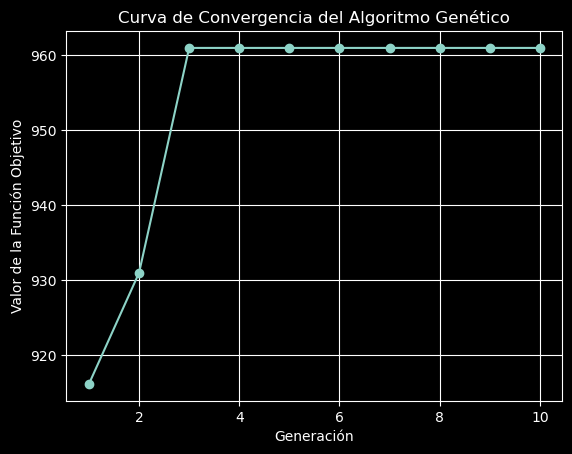

Mejor solución: 31.0 Aptitud: 961.0


In [50]:
import random
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_style("darkgrid")
plt.style.use('dark_background')


# parametros
TAMANIO_POBLACION = 4
LONGITUD_CROMOSOMA = 7
TASA_MUTACION = 0.1
TASA_CRUCE = 0.92
GENERACIONES = 10
X_MIN = 0
X_MAX = 31
EPSILON = 0.001  # Valor pequeño para evitar división por cero en la funcion fitness


#  -----------------------------------------------------------------
# funcion para mapear el valor binario a un rango [-31, 31]
#  -----------------------------------------------------------------
def binario_a_decimal(cromosoma):
    decimal = int(cromosoma, 2)
    x = X_MIN + decimal * (X_MAX - X_MIN) / ((2 ** LONGITUD_CROMOSOMA) - 1)
    return x

#  -----------------------------------------------------------------
# Aqui en las proximas lineas se puede ver que mi funcion objetivo es
# a veces diferente de mi funcion fitness, depende del problema a resolver
#  -----------------------------------------------------------------


#  -----------------------------------------------------------------
# funcion objetivo x^2
#  -----------------------------------------------------------------
def funcion_objetivo(x):
    return x ** 2


#  -----------------------------------------------------------------
# funcion fitness o tambien llamada funcion de aptitud (1/(x^2 + epsilon))
#  -----------------------------------------------------------------
def aptitud(cromosoma):
    x = binario_a_decimal(cromosoma)
    # return 1 / (funcion_objetivo(x) + EPSILON)
    return x ** 2


#  -----------------------------------------------------------------
# se inicializa la poblacion
#  -----------------------------------------------------------------
def inicializar_poblacion(tamanio_poblacion, longitud_cromosoma):
    poblacion = []
    for tp in range(tamanio_poblacion):
        cromosoma = ''
        for lc in range(longitud_cromosoma):
            cromosoma = cromosoma+str(random.randint(0, 1))
        poblacion.append(cromosoma)
    return poblacion

#  -----------------------------------------------------------------
# seleccion por ruleta
#  -----------------------------------------------------------------
def seleccion_ruleta(poblacion, aptitud_total):
    probabilidades = []
    for individuo in poblacion:
        prob = aptitud(individuo) / aptitud_total
        probabilidades.append(prob)

    probabilidades_acumuladas = []
    suma = 0
    for prob in probabilidades:
        suma += prob
        probabilidades_acumuladas.append(suma)

    r = random.random()
    for i, acumulada in enumerate(probabilidades_acumuladas):
        if r <= acumulada:
            return poblacion[i]


#  -----------------------------------------------------------------
# cruce monopunto con probabilidad de cruza pc = 0.92
#  -----------------------------------------------------------------
def cruce_mono_punto(progenitor1, progenitor2, tasa_cruce):
    if random.random() < tasa_cruce:
        punto_cruce = random.randint(1, len(progenitor1) - 1)
        descendiente1 = progenitor1[:punto_cruce] + progenitor2[punto_cruce:]
        descendiente2 = progenitor2[:punto_cruce] + progenitor1[punto_cruce:]
    else:
        descendiente1, descendiente2 = progenitor1, progenitor2
    return descendiente1, descendiente2


#  -----------------------------------------------------------------
# mutacion
#  -----------------------------------------------------------------
def mutacion(cromosoma, tasa_mutacion):
    cromosoma_mutado = ""
    for bit in cromosoma:
        if random.random() < tasa_mutacion:
            cromosoma_mutado = cromosoma_mutado + str(int(not int(bit)))
        else:
            cromosoma_mutado = cromosoma_mutado + bit
    return cromosoma_mutado


#  -----------------------------------------------------------------
# aplicación de operadores geneticos
#  -----------------------------------------------------------------
def algoritmo_genetico(tamanio_poblacion, longitud_cromosoma, tasa_mutacion, tasa_cruce, generaciones):
    poblacion = inicializar_poblacion(tamanio_poblacion, longitud_cromosoma)
    mejor_funcion_objetivo_generaciones = []  # Lista para almacenar la aptitud del mejor individuo y grficar luego

    for generacion in range(generaciones):
        print("Generación:", generacion + 1)

        # se calcula aptitud total para luego
        aptitud_total = sum(aptitud(cromosoma) for cromosoma in poblacion)

        print("Aptitud total:", aptitud_total)

        #  -----------------------------------------------------------------
        # seleccion de progenitores con el metodo ruleta
        progenitores = []
        for _ in range(tamanio_poblacion):
            progenitores.append(seleccion_ruleta(poblacion, aptitud_total))

        #  -----------------------------------------------------------------
        # Cruce
        descendientes = []
        for i in range(0, tamanio_poblacion, 2):
            descendiente1, descendiente2 = cruce_mono_punto(progenitores[i], progenitores[i + 1], tasa_cruce)
            descendientes.extend([descendiente1, descendiente2])

        #  -----------------------------------------------------------------
        # Mutacion
        descendientes_mutados = []
        for descendiente in descendientes:
            descendientes_mutados.append(mutacion(descendiente, tasa_mutacion))

        # Aquí se aplica elitismo
        # Se reemplazan los peores cromosomas con los mejores progenitores
        poblacion.sort(key=aptitud)  # se ordena la poblacion por aptitud en forma ascendente
        # se ordena los descendientes por aptitud en forma descendente
        descendientes_mutados.sort(key=aptitud, reverse=True)
        for i in range(len(descendientes_mutados)):
            if aptitud(descendientes_mutados[i]) > aptitud(poblacion[i]):
                poblacion[i] = descendientes_mutados[i]

        # Mostrar el mejor individuo de la generacion
        mejor_individuo = max(poblacion, key=aptitud)  # Buscar el maximo para la aptitud
        mejor_funcion_objetivo_generaciones.append(funcion_objetivo(binario_a_decimal(mejor_individuo)))

        print("mi", mejor_individuo)
        print("Mejor individuo:", binario_a_decimal(mejor_individuo), "Aptitud:", aptitud(mejor_individuo))
        print("_________________________________________________________________________________")

    # Graficar la evolución de la aptitud
    plt.plot(range(1, generaciones + 1), mejor_funcion_objetivo_generaciones, marker='o')
    plt.xlabel('Generación')
    plt.ylabel('Valor de la Función Objetivo')
    plt.title('Curva de Convergencia del Algoritmo Genético')
    plt.grid(True)
    plt.show()
    return max(poblacion, key=aptitud)  # se retorna el mejor individuo


#  -----------------------------------------------------------------
# ejecucion principal del algoritmo genetico
#  -----------------------------------------------------------------
print("_________________________________________________________________________________")
print()
mejor_solucion = algoritmo_genetico(TAMANIO_POBLACION, LONGITUD_CROMOSOMA, TASA_MUTACION, TASA_CRUCE, GENERACIONES)
print("Mejor solución:", binario_a_decimal(mejor_solucion), "Aptitud:", aptitud(mejor_solucion))